# Reading Pupil Cloud-Format Recordings

In this tutorial, we demonstrate how to load a Neon recording downloaded from [Pupil Cloud](https://docs.pupil-labs.com/neon/pupil-cloud/) and explore the data structure.

## Downloading Sample Data

We provide sample recordings in two formats:

- **Cloud format**: Preprocessed data downloaded from Pupil Cloud with the "Timeseries Data + Scene Video" option
- **Native format**: Raw data from the Neon companion device, also available via Pupil Cloud's "Native Recording Data" option

This tutorial focuses on the **cloud format**. The API for accessing data is nearly identical across both formats.

Sample datasets can be conveniently downloaded using the `get_sample_data()` function, which returns a `pathlib.Path` object pointing to the downloaded and unzipped directory. PyNeon accepts both `Path` and string objects but internally uses `Path` for consistency.

In [1]:
from pyneon import Dataset, Recording, get_sample_data

# Download sample data (if not existing) and return the path
sample_dir = get_sample_data("simple")
native_dir = sample_dir / "Native Recording Data"
cloud_dir = sample_dir / "Timeseries Data + Scene Video"
print(cloud_dir)

C:\Users\User\Documents\GitHub\PyNeon\data\simple\Timeseries Data + Scene Video


A dataset in cloud format has the following directory structure:

In [2]:
from seedir import seedir
seedir(cloud_dir)

Timeseries Data + Scene Video/
├─enrichment_info.txt
├─sections.csv
├─simple1-56fcec49/
│ ├─3d_eye_states.csv
│ ├─blinks.csv
│ ├─events.csv
│ ├─fc7f4f44_0.0-8.235.mp4
│ ├─fixations.csv
│ ├─gaze.csv
│ ├─imu.csv
│ ├─info.json
│ ├─labels.csv
│ ├─saccades.csv
│ ├─scene_camera.json
│ ├─template.csv
│ └─world_timestamps.csv
└─simple2-6ca28606/
  ├─3d_eye_states.csv
  ├─7131b39b_0.0-6.654.mp4
  ├─blinks.csv
  ├─events.csv
  ├─fixations.csv
  ├─gaze.csv
  ├─imu.csv
  ├─info.json
  ├─labels.csv
  ├─saccades.csv
  ├─scene_camera.json
  ├─template.csv
  └─world_timestamps.csv


PyNeon provides a `Dataset` class to represent a collection of recordings. A dataset can contain one or more recordings. Here, we instantiate a `Dataset` by providing the path to the cloud format data directory.

In [3]:
dataset = Dataset(cloud_dir)
print(dataset)

Dataset | 2 recordings


`Dataset` provides index-based access to its recordings through the `recordings` attribute, which contains a list of `Recording` instances. Individual recordings can be accessed by index:

In [4]:
rec = dataset[0]  # Internally accesses the recordings attribute
print(type(rec))
print(rec.recording_dir)

<class 'pyneon.recording.Recording'>
C:\Users\User\Documents\GitHub\PyNeon\data\simple\Timeseries Data + Scene Video\simple1-56fcec49


Alternatively, you can directly load a single `Recording` by specifying the recording's folder path:

In [5]:
recording_dir = cloud_dir / "simple2-6ca28606"
rec = Recording(recording_dir)
print(type(rec))
print(rec.recording_dir)

<class 'pyneon.recording.Recording'>
C:\Users\User\Documents\GitHub\PyNeon\data\simple\Timeseries Data + Scene Video\simple2-6ca28606


## Recording Metadata and Data Access

You can quickly obtain an overview of a `Recording` by printing the instance. This displays basic metadata (recording ID, wearer ID, recording start time, and duration) and the paths to available data files. Note that at this point, data files are located but not yet loaded into memory.

In [6]:
print(rec)


Data format: cloud
Recording ID: 6ca28606-966d-486e-afe4-f4a424492d8c
Wearer ID: 028e4c69-f333-4751-af8c-84a09af079f5
Wearer name: Pilot
Recording start time: 2025-12-18 17:15:47.736000
Recording duration: 6654000000 ns (6.654 s)



As shown in the output above, this recording contains all available data modalities. This tutorial focuses on non-video data; refer to the [video processing tutorial](video.ipynb) for scene video analysis.

Individual data streams can be accessed as properties of the `Recording` instance. For example, `recording.gaze` retrieves gaze data and loads it into memory. If you attempt to access unavailable data, PyNeon returns `None` and issues a warning message.

In [7]:
# Gaze and fixation data are available
gaze = rec.gaze
print(f"recording.gaze is an instance of {type(gaze)}")

saccades = rec.saccades
print(f"recording.saccades is an instance of {type(saccades)}")

scene_video = rec.scene_video
print(f"recording.scene_video is an instance of {type(scene_video)}")

recording.gaze is an instance of <class 'pyneon.stream.Stream'>
recording.saccades is an instance of <class 'pyneon.events.Events'>
recording.scene_video is an instance of <class 'pyneon.video.video.Video'>


PyNeon reads tabular CSV files into specialized classes that inherit from two base classes: `Stream` and `Events`. All of these classes contain a `data` attribute that holds the tabular data as a `pandas.DataFrame` [(reference)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). 

- `Stream` contains continuous or semi-continuous data streams, including:
  - Gaze (`Recoding.gaze`, from `gaze.csv`)
  - IMU (`Recording.imu`, from `imu.csv`)
  - 3D eye states (`Recording.eye_states`, from `3d_eye_states.csv`)
  - Any other data stream that is indexed by timestamps in the same Unix nanosecond format
- `Events` contains sparse event data (avoiding confusion with data from `events.csv`), including:
  - Fixations (`Recording.fixations`, from `fixations.csv`)
  - Saccades (`Recording.saccades`, from `saccades.csv`)
  - Blinks (`Recording.blinks`, from `blinks.csv`)
  - Events (better thought of as messages/triggers, `Recording.events`, from `events.csv`)
  - Any other event data that is tabular and indexed by timestamps in the same Unix nanosecond format

## Data Access as Pandas DataFrames

The core of `BaseTabular` is the `data` attribute - a `pandas.DataFrame` that provides a standard Python data structure for tabular data manipulation. For example, you can view the first 5 rows using `data.head()` and inspect column data types with `data.dtypes`. 

While you can reassign `data` to a separate variable, note that specialized processing methods operate at the class level and not on standalone DataFrames.

In [8]:
print(gaze.data.head())
print(gaze.data.dtypes)

                     gaze x [px]  gaze y [px]  worn  fixation id  blink id  \
timestamp [ns]                                                               
1766074550059895270      777.823      645.708     1         <NA>      <NA>   
1766074550064895270      778.840      650.667     1         <NA>      <NA>   
1766074550069895270      789.575      644.583     1         <NA>      <NA>   
1766074550075020270      790.720      643.566     1         <NA>      <NA>   
1766074550080020270      788.473      642.554     1         <NA>      <NA>   

                     azimuth [deg]  elevation [deg]  
timestamp [ns]                                       
1766074550059895270      -1.246504        -2.128223  
1766074550064895270      -1.181023        -2.448048  
1766074550069895270      -0.488220        -2.055796  
1766074550075020270      -0.414293        -1.990205  
1766074550080020270      -0.559308        -1.924897  
gaze x [px]        float64
gaze y [px]        float64
worn                 

In [9]:
print(saccades.data.head())
print(saccades.data.dtypes)

            start timestamp [ns]   end timestamp [ns]  duration [ms]  \
saccade id                                                             
1            1766074550185020270  1766074550200020270             15   
2            1766074550500394270  1766074550530409270             30   
3            1766074550790643270  1766074550855643270             65   
4            1766074551261017270  1766074551316141270             55   
5            1766074551431266270  1766074551461266270             30   

            amplitude [px]  amplitude [deg]  mean velocity [px/s]  \
saccade id                                                          
1                32.038345         2.058745           2169.577393   
2                46.000240         2.955818           1558.823608   
3               229.634521        14.681583           3085.043457   
4               116.869461         7.418345           2315.360352   
5                42.120010         2.639519           1429.373535   

           

PyNeon performs the following preprocessing when reading CSV files:

1. Removes redundant `section id` and `recording id` columns present in the raw files
2. Sets the `timestamp [ns]` (or `start timestamp [ns]` for event files) column as the DataFrame index
3. Automatically infers and assigns appropriate data types to columns—for example, `Int64` for timestamps, `Int32` for event IDs, and `float64` for numerical measurements like gaze location and pupil size

Like any `pandas.DataFrame`, you can access individual rows, columns, or subsets using standard indexing and slicing methods. For example, `data.iloc[0]` returns the first row, and `gaze['gaze x [px]']` (or equivalently `gaze.data['gaze x [px]']`) returns the gaze x-coordinate column.

In [10]:
print(f"First row of gaze data:\n{gaze.data.iloc[0]}\n")
print(f"All gaze x values:\n{gaze['gaze x [px]']}")

First row of gaze data:
gaze x [px]         777.823
gaze y [px]         645.708
worn                    1.0
fixation id            <NA>
blink id               <NA>
azimuth [deg]     -1.246504
elevation [deg]   -2.128223
Name: 1766074550059895270, dtype: Float64

All gaze x values:
timestamp [ns]
1766074550059895270    777.823
1766074550064895270    778.840
1766074550069895270    789.575
1766074550075020270    790.720
1766074550080020270    788.473
                        ...   
1766074553353010270    719.002
1766074553358010270    721.969
1766074553363010270    725.065
1766074553368010270    731.852
1766074553373010270    745.475
Name: gaze x [px], Length: 663, dtype: float64


## Useful Properties and Methods for Streams and Events

Beyond analyzing the `data` DataFrame directly, `Stream` and `Events` instances provide several convenience properties and methods for Neon-specific analysis. For instance, the `ts` property provides quick access to all timestamps as a `numpy.ndarray` [(reference)](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html).

Unix timestamps in nanoseconds are typically inconvenient for human interpretation. PyNeon provides the `times` property, which represents relative time (in seconds) from the stream start—different from the recording start. Access this as a `numpy.ndarray` via the `times` property.


In [11]:
print(f"First five timestamps:\n{gaze.ts[:5]}")
print(f"First five times:\n{gaze.times[:5]}")

First five timestamps:
[1766074550059895270 1766074550064895270 1766074550069895270
 1766074550075020270 1766074550080020270]
First five times:
[0.       0.005    0.01     0.015125 0.020125]


For a comprehensive list of available properties and methods, refer to the [API reference documentation](https://ncc-brain.github.io/PyNeon/reference/stream.html). Subsequent tutorials (for example, [interpolation and concatenation of streams](interpolate_and_concat.ipynb)) demonstrate additional functionality.

## Example: Plotting Gaze and Saccade Data

Below we demonstrate how to plot gaze and saccade data. Since PyNeon stores data in `pandas.DataFrame` format, you can use any plotting library that supports this structure. In this example, we use `matplotlib` to plot gaze coordinates and highlight saccade intervals.

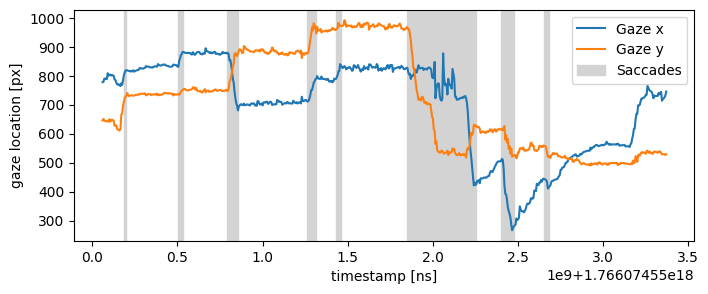

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))

# Plot the gaze data
(gaze_l,) = plt.plot(gaze["gaze x [px]"], label="Gaze x")
(gaze_r,) = plt.plot(gaze["gaze y [px]"], label="Gaze y")

# Visualize the saccades
for sac_start, sac_end in zip(saccades.start_ts, saccades.end_ts):
    sac = plt.axvspan(sac_start, sac_end, color="lightgray", label="Saccades")

plt.xlabel("timestamp [ns]")
plt.ylabel("gaze location [px]")
plt.legend(handles=[gaze_l, gaze_r, sac])
plt.show()

## Visualizing Gaze Distribution

To visualize the spatial distribution of gaze data, we can create a heatmap with fixation locations overlaid. The `plot_distribution()` method generates this visualization by combining gaze density with fixation markers.

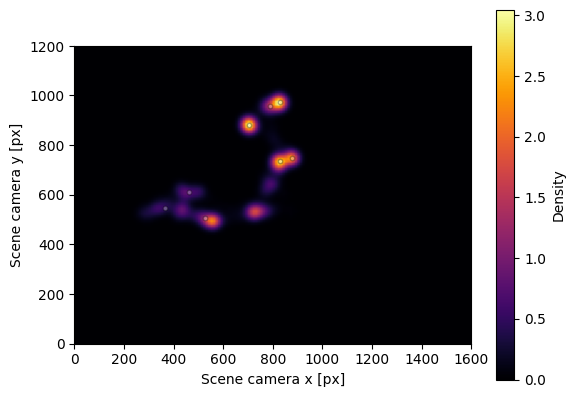

In [13]:
fig, ax = rec.plot_distribution()

The plot appears relatively sparse due to the short duration of this sample recording. For longer recordings with more gaze samples, `plot_distribution()` provides a valuable tool for visualizing gaze and fixation patterns across the scene.